## FERC <> EIA Granular Connections

Notes on the type of problem we are trying to solve:
- A classification problem
    - A Multi-Class Classification problem*
- A deterministic problem
- A record linkage problem

Right now, we are using the recordlinkage package. We're using logistic regression classifier because it fits all of the above.

What we still need:
- determine how to restrict the results to one eia record per ferc record! - DONE (with more fine tuning to come)
- Remove false granularities in the MUL - DONE
    - Partent/Child granularities - DONE
    - Peer/peer granularities - DONE
- fine tune the comparison metric for heat rate and total fuel cost. (Issue #22)
- add in additional FERC tabels (Issue #21)
- more test data!
- so, so much more.

To consider:
- Maybe we want to run the records with fuel cost data through a different matching model...

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import pudl
import pudl.constants as pc
import pudl.extract.ferc1
import sqlalchemy as sa
import logging
import sys
import copy
from copy import deepcopy
import scipy

import yaml

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
formatter = logging.Formatter('%(message)s')
handler.setFormatter(formatter)
logger.handlers = [handler]

In [4]:
sys.path.append("../")
from pudl.output.ferc1 import *
from ferc_eia_connections import *
from plant_part_agg_eia import *
from plant_parts import plant_parts
import ferc_eia_connections
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_engine = sa.create_engine(pudl_settings["pudl_db"])
pd.options.display.max_columns = None


### Pull in data (EIA, FERC and training)

In [5]:
table_compiler = CompileTables(pudl_engine, freq='AS', rolling=True)

In [6]:
parts_compilers = CompilePlantParts(table_compiler, plant_parts, clobber=True)

In [7]:
plant_parts_df = parts_compilers.generate_master_unit_list()
plant_parts_df = plant_parts_df[plant_parts_df['true_gran'] == True]

beginning the aggregation for generation_eia923
grabbing generation_eia923 from the sqlite db
Converting the dtypes of: generation_eia923
beginning the aggregation for generators_eia860
grabbing generators_eia860 from the sqlite db
Converting the dtypes of: generators_eia860
beginning the aggregation for mcoe
grabbing mcoe from the output object
filling in fuel cost NaNs with rolling averages
Converting the dtypes of: mcoe
grabbing ownership_eia860 from the sqlite db
Converting the dtypes of: ownership_eia860
grabbing boiler_generator_assn_eia860 from the sqlite db
Converting the dtypes of: boiler_generator_assn_eia860
grabbing generators_entity_eia from the sqlite db
Converting the dtypes of: generators_entity_eia
begin aggregation for: plant_prime_fuel
begin aggregation for: plant_technology
begin aggregation for: plant_prime_mover
begin aggregation for: plant_gen
begin aggregation for: plant_unit
begin aggregation for: plant
grabbing utilities_eia from the sqlite db
Converting the d

In [8]:
# compliers for training data
compiler_train = ferc_eia_connections.TrainXlxsCompiler('pudl_machine_learning.xlsx')

In [9]:
train_df_ids = ferc_eia_connections.prep_train_connections(parts_compilers,compiler_train)

grabbing xlxs file.


In [10]:
train_df_ids.groupby(['plant_part']).agg({'respondent_id': 'count'})

,respondent_id
plant_part,
plant,235
plant_gen,17
plant_prime_mover,46
plant_technology,3
plant_unit,84


In [11]:
# pudl output object for ferc data
pudl_out = pudl.output.pudltabl.PudlTabl(pudl_engine,freq='AS')

In [12]:
steam_cleaned = ferc_eia_connections.prep_ferc_data(pudl_out)

Converting the dtypes of: ferc1 plant records


In [13]:
steam_cleaned.head()

,report_year,utility_id_ferc1,plant_name_ferc1,utility_id_pudl,plant_id_pudl,plant_id_ferc1,capacity_factor,capacity_mw,net_generation_mwh,opex_fuel,fuel_cost_per_mwh,total_fuel_cost,total_mmbtu,construction_year,installation_year,fuel_type_code_pudl,plant_type,fuel_cost_per_mmbtu,heat_rate_mmbtu_mwh,plant_id_report_year
record_id_ferc,,,,,,,,,,,,,,,,,,,,
f1_steam_2009_12_122_0_1,2009,122,big stone,226,55,1,0.825667,122.85,888555.0,20928687.0,23.553620,1.678663e+07,9298857.232,1975,1975,coal,steam,1.805236,10.465145,55_2009
f1_steam_2010_12_122_0_1,2010,122,big stone,226,55,1,0.785593,122.85,845429.0,15012830.0,17.757647,1.711106e+07,8656502.406,1975,1975,coal,steam,1.976671,10.239183,55_2010
f1_steam_2011_12_122_0_1,2011,122,big stone,226,55,1,0.574079,122.85,617804.0,12214984.0,19.771617,1.408465e+07,6475259.732,1975,1975,coal,steam,2.175148,10.481091,55_2011
f1_steam_2012_12_122_0_1,2012,122,big stone,226,55,1,0.736871,122.85,792995.0,20139513.0,25.396772,1.793872e+07,8568118.948,1975,1975,coal,steam,2.093659,10.804758,55_2012
f1_steam_2013_12_122_0_1,2013,122,big stone,226,55,1,0.716554,122.85,771131.0,16636662.0,21.574365,1.625351e+07,8177204.188,1975,1975,coal,steam,1.987661,10.604170,55_2013


### Generate known test datasets

In [14]:
# generate the list of the records in the EIA and FERC records that exist
# in the training data
eia_known = (plant_parts_df.merge(train_df_ids.reset_index().drop(columns=['record_id_ferc'])[['record_id_eia']],
                          left_index=True,
                          right_on=['record_id_eia']).
            drop_duplicates(subset=['record_id_eia']).
            set_index('record_id_eia').
            astype({'total_fuel_cost':float,
                    'total_mmbtu':float}))

ferc_known = (steam_cleaned.merge(train_df_ids.reset_index().drop(columns=['record_id_eia'])[['record_id_ferc']],
                          left_index=True,
                          right_on=['record_id_ferc']).
             drop_duplicates(subset=['record_id_ferc']).
             set_index('record_id_ferc').
             astype({'total_fuel_cost':float,
                     'total_mmbtu':float}))

In [15]:
plant_parts_df

,plant_id_eia,report_date,plant_part,generator_id,unit_id_pudl,prime_mover_code,energy_source_code_1,technology_description,utility_id_eia,fraction_owned,true_gran,appro_part_label,appro_record_id_eia,capacity_factor,capacity_mw,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_type_code_pudl,heat_rate_mmbtu_mwh,installation_year,net_generation_mwh,ownership,plant_id_pudl,plant_name_eia,total_fuel_cost,total_mmbtu,utility_id_pudl,utility_name_eia,report_year,plant_id_report_year,plant_name_new
record_id_eia,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
120_dfo_2009_plant_prime_fuel_total_803,120,2009-01-01,plant_prime_fuel,NaN,NaN,NaN,DFO,NaN,803,1.0,True,plant_prime_fuel,120_DFO_2009_plant_prime_fuel_total_803,0.0,56.3,NaN,NaN,oil,NaN,1978,0.0,total,1017,Yucca,0.0,0.0,31,Arizona Public Service Co,2009,1017_2009,Yucca DFO
120_dfo_2009_plant_prime_fuel_total_9216,120,2009-01-01,plant_prime_fuel,NaN,NaN,NaN,DFO,NaN,9216,1.0,True,plant_prime_fuel,120_DFO_2009_plant_prime_fuel_total_9216,0.0,26.0,NaN,NaN,oil,NaN,1978,0.0,total,1017,Yucca,0.0,0.0,2068,Imperial Irrigation District,2009,1017_2009,Yucca DFO
120_ng_2009_plant_prime_fuel_total_803,120,2009-01-01,plant_prime_fuel,NaN,NaN,NaN,NG,NaN,803,1.0,True,plant_prime_fuel,120_NG_2009_plant_prime_fuel_total_803,0.0,216.5,NaN,NaN,gas,NaN,2008,0.0,total,1017,Yucca,0.0,0.0,31,Arizona Public Service Co,2009,1017_2009,Yucca NG
307_dfo_2009_plant_prime_fuel_total_13960,307,2009-01-01,plant_prime_fuel,NaN,NaN,NaN,DFO,NaN,13960,1.0,True,plant_prime_fuel,307_DFO_2009_plant_prime_fuel_total_13960,0.0,19.0,NaN,NaN,oil,NaN,1972,0.0,total,10018,North Island,0.0,0.0,2667,NRG Cabrillo Power Ops Inc,2009,10018_2009,North Island DFO
307_ng_2009_plant_prime_fuel_total_13960,307,2009-01-01,plant_prime_fuel,NaN,NaN,NaN,NG,NaN,13960,1.0,True,plant_prime_fuel,307_NG_2009_plant_prime_fuel_total_13960,0.0,18.0,NaN,NaN,gas,NaN,1972,0.0,total,10018,North Island,0.0,0.0,2667,NRG Cabrillo Power Ops Inc,2009,10018_2009,North Island NG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62936_2018_plant_total_62778,62936,2018-01-01,plant,NaN,NaN,NaN,NaN,NaN,62778,1.0,True,plant,62936_2018_plant_total_62778,0.0,144.0,NaN,NaN,wind,NaN,NaN,0.0,total,13845,rattlesnake,0.0,0.0,NaN,NaN,2018,13845_2018,rattlesnake
62937_2018_plant_total_62731,62937,2018-01-01,plant,NaN,NaN,NaN,NaN,NaN,62731,1.0,True,plant,62937_2018_plant_total_62731,0.0,6.0,NaN,NaN,other,NaN,2018,0.0,total,13846,athens bess,0.0,0.0,NaN,NaN,2018,13846_2018,athens bess
62938_2018_plant_total_62792,62938,2018-01-01,plant,NaN,NaN,NaN,NaN,NaN,62792,1.0,True,plant,62938_2018_plant_total_62792,0.0,106.7,NaN,NaN,wind,NaN,NaN,0.0,total,13847,glen ullin energy center,0.0,0.0,NaN,NaN,2018,13847_2018,glen ullin energy center


# Omigosh the actual Matching

In [16]:
import statistics

In [17]:
dfA_known = ferc_known
dfB_known = eia_known
dfA = steam_cleaned[steam_cleaned['report_year'] == 2018]
dfB = plant_parts_df[plant_parts_df['report_year'] == 2018]

In [18]:
print(dfA_known.shape)
print(dfB_known.shape)
print(dfA.shape)
print(dfB.shape)

(243, 20)
(294, 31)
(641, 20)
(40980, 31)


#### Making Comparison Feature Vectors

In [19]:
features_all = ferc_eia_connections.make_features(dfA, dfB, block_col='plant_id_report_year')
features_known = ferc_eia_connections.make_features(dfA_known, dfB_known, block_col='plant_id_report_year')

In [20]:
features_all.describe().T

,count,mean,std,min,25%,50%,75%,max
plant_name,7789.0,0.733322,0.119058,0.000000e+00,6.664991e-01,7.405229e-01,8.244048e-01,0.955556
net_generation_mwh,7789.0,0.062129,0.219007,0.000000e+00,0.000000e+00,5.516306e-269,2.448151e-46,1.000000
capacity_mw,7789.0,0.102523,0.264837,2.541439e-144,2.763763e-19,3.265611e-09,5.501345e-03,1.000000
total_fuel_cost,7789.0,0.009089,0.074440,0.000000e+00,0.000000e+00,0.000000e+00,1.038235e-198,1.000000
total_mmbtu,7789.0,0.027421,0.145212,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
capacity_factor,7789.0,0.895205,0.132232,0.000000e+00,8.465672e-01,9.551949e-01,9.892932e-01,1.000000
fuel_cost_per_mmbtu,7789.0,0.364226,0.444797,0.000000e+00,0.000000e+00,0.000000e+00,9.148649e-01,0.999960
heat_rate_mmbtu_mwh,7789.0,0.307172,0.416834,0.000000e+00,0.000000e+00,0.000000e+00,8.221699e-01,1.000000
fuel_type_code_pudl,7789.0,0.784440,0.411237,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000
installation_year,7789.0,0.459879,0.498420,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000


In [21]:
features_known.describe().T

,count,mean,std,min,25%,50%,75%,max
plant_name,271.0,0.767881,0.110224,0.000000e+00,6.985155e-01,7.728938e-01,8.518519e-01,0.939394
net_generation_mwh,271.0,0.196000,0.375697,0.000000e+00,0.000000e+00,1.306026e-68,1.086685e-02,1.000000
capacity_mw,271.0,0.317827,0.430438,8.445037e-82,3.248732e-15,1.244688e-03,8.705506e-01,1.000000
total_fuel_cost,271.0,0.004249,0.030166,0.000000e+00,0.000000e+00,0.000000e+00,8.330184e-62,0.367057
total_mmbtu,271.0,0.035557,0.174552,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
capacity_factor,271.0,0.929298,0.108795,5.093643e-01,9.197354e-01,9.812931e-01,9.959166e-01,1.000000
fuel_cost_per_mmbtu,271.0,0.523243,0.456100,0.000000e+00,0.000000e+00,8.305041e-01,9.543869e-01,0.999960
heat_rate_mmbtu_mwh,271.0,0.453220,0.443137,0.000000e+00,0.000000e+00,5.191772e-01,9.368801e-01,1.000000
fuel_type_code_pudl,271.0,0.856089,0.351649,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000
installation_year,271.0,0.590406,0.492669,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000


### Classificaiton Models

In [22]:
import recordlinkage as rl
import warnings
warnings.filterwarnings('ignore')

In [23]:
%%time
# this cell takes a fair amount of time (> 2 minutes on my computer)
# it is testing an array of model hyper parameters and 
# cross-vaildating with the training data. It returns a df with losts
# of result scores to be used to find the best resutls
results_options = ferc_eia_connections.test_model_parameters(
    features_known, train_df_ids.index, 10)

CPU times: user 2min 5s, sys: 795 ms, total: 2min 6s
Wall time: 2min 20s


In [24]:
results_options = results_options.sort_values(['f_score','precision','accuracy'],ascending=False)
best = results_options.head(1)

In [25]:
best

,solver,precision,f_score,accuracy,c,cw,penalty,l1,multi_class,predictions,coef,interc
0,sag,0.822134,0.866419,0.747137,1,None,l2,None,multinomial,199,"[0.17478786903893181, 0.9290491091298246, 0.73...",-2.758408


In [26]:
prediction_df = fit_predict_lrc(best,features_known, features_all, train_df_ids)

In [27]:
coefs = best['coef'].values[0]
weighted_feats_all = weight_features(features_all,coefs)
feats_all = calc_match_stats(weighted_feats_all)

results_weighted = weight_features(prediction_df,coefs)
results = calc_match_stats(results_weighted)
results = results.merge(feats_all[['iqr']],
                        left_index=True,
                        right_index=True,
                        how='left',
                        suffixes=("","_all"))

In [28]:
coefs

array([ 0.17478787,  0.92904911,  0.7304709 ,  0.10783196,  0.39336422,
        0.61973527, -0.91480272,  0.8473338 ,  0.56120352,  0.29912717,
        1.86848008])

In [29]:
features_all.columns

Index(['plant_name', 'net_generation_mwh', 'capacity_mw', 'total_fuel_cost',
       'total_mmbtu', 'capacity_factor', 'fuel_cost_per_mmbtu',
       'heat_rate_mmbtu_mwh', 'fuel_type_code_pudl', 'installation_year',
       'utility_id_pudl'],
      dtype='object')

In [39]:
winners = calc_wins(results, dfA, .2)
murk_df = calc_murk(results,.2)

matches vs total ferc:  0.9
wins vs total ferc:     0.7
wins vs matches:        0.78
murk vs matches:        0.19
ties vs matches:        0.024


#### Investigation of Murky Wins

In [40]:
# choose a murk... 
murk_df.sample()

,,score,capacity_factor,capacity_mw,fuel_cost_per_mmbtu,fuel_type_code_pudl,heat_rate_mmbtu_mwh,installation_year,net_generation_mwh,plant_name,total_fuel_cost,total_mmbtu,utility_id_pudl,rank,diffs,count,iqr,iqr_all
record_id_ferc,record_id_eia,,,,,,,,,,,,,,,,,
f1_steam_2018_12_148_1_3,2966_gt_2018_plant_prime_mover_total_15474,3.528187,0.613313,0.039744,-0.0,0.561204,0.0,0.299127,9.612848e-12,0.146319,3.079012e-52,0.0,1.86848,1.0,0.036011,5,0.299127,0.448724


In [41]:
# grab the f1_id and peer into the plant
f1_id = 'f1_steam_2018_12_89_0_2'
results.loc[f1_id]

,score,capacity_factor,capacity_mw,fuel_cost_per_mmbtu,fuel_type_code_pudl,heat_rate_mmbtu_mwh,installation_year,net_generation_mwh,plant_name,total_fuel_cost,total_mmbtu,utility_id_pudl,rank,diffs,count,iqr,iqr_all
record_id_eia,,,,,,,,,,,,,,,,,
7991_ca_2018_plant_prime_mover_owned_11479,3.449557,0.599840,0.000409,-0.0,0.561204,0.0,0.299127,9.106104e-75,0.120498,0.0,0.0,1.86848,7.0,NaN,7,0.028565,1.876166
7991_ca_2018_plant_prime_mover_total_11479,3.450332,0.599840,0.001183,-0.0,0.561204,0.0,0.299127,5.749104e-68,0.120498,0.0,0.0,1.86848,6.0,0.000774,7,0.028565,1.876166
7991_2018_plant_owned_11479,3.450882,0.599840,0.000409,-0.0,0.561204,0.0,0.299127,9.106104e-75,0.121822,0.0,0.0,1.86848,5.0,0.000550,7,0.028565,1.876166
7991_ct2_2018_plant_gen_total_11479,3.458328,0.608699,0.000713,-0.0,0.561204,0.0,0.299127,3.905234e-67,0.120104,0.0,0.0,1.86848,4.0,0.007446,7,0.028565,1.876166
7991_1_2018_plant_gen_total_11479,3.459221,0.608783,0.000713,-0.0,0.561204,0.0,0.299127,4.969595e-57,0.120914,0.0,0.0,1.86848,3.0,0.000893,7,0.028565,1.876166
7991_ct_2018_plant_prime_mover_total_11479,3.499123,0.619694,0.030121,-0.0,0.561204,0.0,0.299127,5.363376e-29,0.120498,0.0,0.0,1.86848,2.0,0.039902,7,0.028565,1.876166
7991_2018_plant_total_11479,3.801297,0.612505,0.252946,-0.0,0.561204,0.0,0.299127,8.521356e-02,0.121822,0.0,0.0,1.86848,1.0,0.302174,7,0.028565,1.876166


In [42]:
dfA.loc[[f1_id]]

,report_year,utility_id_ferc1,plant_name_ferc1,utility_id_pudl,plant_id_pudl,plant_id_ferc1,capacity_factor,capacity_mw,net_generation_mwh,opex_fuel,fuel_cost_per_mwh,total_fuel_cost,total_mmbtu,construction_year,installation_year,fuel_type_code_pudl,plant_type,fuel_cost_per_mmbtu,heat_rate_mmbtu_mwh,plant_id_report_year
record_id_ferc,,,,,,,,,,,,,,,,,,,,
f1_steam_2018_12_89_0_2,2018,89,west campus,171,626,426,0.232478,154.0,313621.6,10822296.0,34.507496,1.435048e+07,3660624.981,2005,2005,gas,steam,3.920228,11.672107,626_2018


In [43]:
dfB[((dfB['plant_id_eia'] == 7991)
     #& (dfB['utility_id_eia'] == 343)
    )
    #& ((dfB['plant_part'] == 'plant') | (dfB['plant_part'] == 'plant_unit'))
    #& ((dfB['generator_id'] == '8') | (dfB['generator_id'] == '8C') | (dfB['unit_id_pudl'] == 3) | (dfB['generator_id'] == '8D'))
   ]

,plant_id_eia,report_date,plant_part,generator_id,unit_id_pudl,prime_mover_code,energy_source_code_1,technology_description,utility_id_eia,fraction_owned,true_gran,appro_part_label,appro_record_id_eia,capacity_factor,capacity_mw,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_type_code_pudl,heat_rate_mmbtu_mwh,installation_year,net_generation_mwh,ownership,plant_id_pudl,plant_name_eia,total_fuel_cost,total_mmbtu,utility_id_pudl,utility_name_eia,report_year,plant_id_report_year,plant_name_new
record_id_eia,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7991_ca_2018_plant_prime_mover_owned_19540,7991,2018-01-01,plant_prime_mover,NaN,NaN,CA,NaN,NaN,19540,0.25,True,plant_prime_mover,7991_CA_2018_plant_prime_mover_owned_19540,0.168272,15.325,NaN,NaN,gas,NaN,2005,22590.0,owned,626,West Campus Cogeneration Facility,0.0,0.0,NaN,NaN,2018,626_2018,West Campus Cogeneration Facility CA
7991_ca_2018_plant_prime_mover_owned_11479,7991,2018-01-01,plant_prime_mover,NaN,NaN,CA,NaN,NaN,11479,0.75,True,plant_prime_mover,7991_CA_2018_plant_prime_mover_owned_11479,0.168272,45.975,NaN,NaN,gas,NaN,2005,67770.0,owned,626,West Campus Cogeneration Facility,0.0,0.0,171,Madison Gas & Electric Co,2018,626_2018,West Campus Cogeneration Facility CA
7991_ca_2018_plant_prime_mover_total_11479,7991,2018-01-01,plant_prime_mover,NaN,NaN,CA,NaN,NaN,11479,1.00,True,plant_prime_mover,7991_CA_2018_plant_prime_mover_total_11479,0.168272,61.300,NaN,NaN,gas,NaN,2005,90360.0,total,626,West Campus Cogeneration Facility,0.0,0.0,171,Madison Gas & Electric Co,2018,626_2018,West Campus Cogeneration Facility CA
7991_ca_2018_plant_prime_mover_total_19540,7991,2018-01-01,plant_prime_mover,NaN,NaN,CA,NaN,NaN,19540,1.00,True,plant_prime_mover,7991_CA_2018_plant_prime_mover_total_19540,0.168272,61.300,NaN,NaN,gas,NaN,2005,90360.0,total,626,West Campus Cogeneration Facility,0.0,0.0,NaN,NaN,2018,626_2018,West Campus Cogeneration Facility CA
7991_ct_2018_plant_prime_mover_total_11479,7991,2018-01-01,plant_prime_mover,NaN,NaN,CT,NaN,NaN,11479,1.00,True,plant_prime_mover,7991_CT_2018_plant_prime_mover_total_11479,0.232343,108.000,NaN,NaN,gas,NaN,2005,219815.0,total,626,West Campus Cogeneration Facility,0.0,0.0,171,Madison Gas & Electric Co,2018,626_2018,West Campus Cogeneration Facility CT
7991_1_2018_plant_gen_total_11479,7991,2018-01-01,plant_gen,1,NaN,NaN,NaN,NaN,11479,1.00,True,plant_gen,7991_1_2018_plant_gen_total_11479,0.267823,54.000,NaN,NaN,gas,NaN,2005,126691.0,total,626,West Campus Cogeneration Facility,0.0,0.0,171,Madison Gas & Electric Co,2018,626_2018,West Campus Cogeneration Facility 1
7991_ct2_2018_plant_gen_total_11479,7991,2018-01-01,plant_gen,CT2,NaN,NaN,NaN,NaN,11479,1.00,True,plant_gen,7991_CT2_2018_plant_gen_total_11479,0.196863,54.000,NaN,NaN,gas,NaN,2005,93124.0,total,626,West Campus Cogeneration Facility,0.0,0.0,171,Madison Gas & Electric Co,2018,626_2018,West Campus Cogeneration Facility CT2
7991_2018_plant_owned_19540,7991,2018-01-01,plant,NaN,NaN,NaN,NaN,NaN,19540,0.25,True,plant,7991_2018_plant_owned_19540,0.168272,15.325,NaN,NaN,gas,NaN,2005,22590.0,owned,626,West Campus Cogeneration Facility,0.0,0.0,NaN,NaN,2018,626_2018,West Campus Cogeneration Facility
7991_2018_plant_owned_11479,7991,2018-01-01,plant,NaN,NaN,NaN,NaN,NaN,11479,0.75,True,plant,7991_2018_plant_owned_11479,0.168272,45.975,NaN,NaN,gas,NaN,2005,67770.0,owned,626,West Campus Cogeneration Facility,0.0,0.0,171,Madison Gas & Electric Co,2018,626_2018,West Campus Cogeneration Facility


In [44]:
def plot_all_hist(all_df,results_df,murk_df, winners_df, range):
    if all_df is not None:
        plt.hist(all_df['score'], 
                 range=range,
                 bins=100,
                 color="pink",
                 label='all options'
                )
    if results_df is not None:
        plt.hist(results_df['score'], 
                 range=range,
                 bins=100,
                 color="purple",
                 label='all model matches'
                )
    if winners_df is not None:
        plt.hist(winners_df['score'], 
                 range=range,
                 bins=100,
                 color="turquoise",
                 label='winning options'
                )
    if murk_df is not None:
        plt.hist(murk_df['score'], 
                 range=range,
                 bins=100,
                 color="grey",
                 label='murky wins'
                )

    plt.title(f'weighted score of comparision features')
    plt.xlabel('weighted sum')
    plt.ylabel(None)
    plt.legend()
    plt.show()

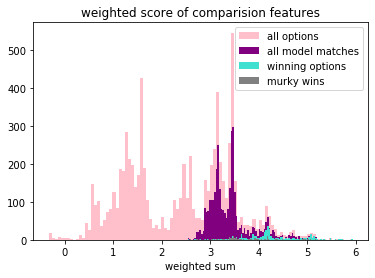

In [45]:
plot_all_hist(feats_all,results,murk_df, winners, range=None)

In [46]:
wins = (winners.reset_index().merge(plant_parts_df.
              reset_index()[['record_id_eia','plant_part','capacity_mw']],
              on=['record_id_eia'],
              how='left',
              suffixes=('_feature','')
             ).
        groupby(['plant_part']).
        agg({'capacity_mw':sum,
             'score': 'count'}).
        assign(count_w=lambda x: x.capacity_mw * x.score,
               percent_w=lambda x: x.count_w/x.sum()['count_w'],
               percent=lambda x: x.score/x.sum()['score'],
              )
       )

wins

,capacity_mw,score,count_w,percent_w,percent
plant_part,,,,,
plant,193678.87888,297,5.752263e+07,0.961876,0.661470
plant_gen,4473.82792,30,1.342148e+05,0.002244,0.066815
plant_prime_mover,8654.89040,48,4.154347e+05,0.006947,0.106904
plant_technology,4042.40000,6,2.425440e+04,0.000406,0.013363
plant_unit,25088.35888,68,1.706008e+06,0.028527,0.151448
